<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Raw-ECG-plot" data-toc-modified-id="Raw-ECG-plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Raw ECG plot</a></span></li></ul></li><li><span><a href="#QRS-Segmentation" data-toc-modified-id="QRS-Segmentation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>QRS Segmentation</a></span><ul class="toc-item"><li><span><a href="#QRS-identified" data-toc-modified-id="QRS-identified-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>QRS identified</a></span></li><li><span><a href="#QRS-separated" data-toc-modified-id="QRS-separated-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>QRS separated</a></span></li></ul></li><li><span><a href="#QRS-Analysis" data-toc-modified-id="QRS-Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>QRS Analysis</a></span><ul class="toc-item"><li><span><a href="#Individual-signals-FFT" data-toc-modified-id="Individual-signals-FFT-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Individual signals FFT</a></span></li><li><span><a href="#Signals-PSD" data-toc-modified-id="Signals-PSD-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Signals PSD</a></span></li></ul></li></ul></div>

# ECG Data Analysis

This notebook presents the code to analyze an electrocardiogram signal (ECG) and extract useful features. With this goal, a sample ECG signal is first plotted in order to get a "feeling" of how the signal behaves and what patterns can be exploited. 

Then, a simple and limited algorithm is implemented to identify and separate the QRS complex. All the segmented QRS complex signals are utilized to form two different signals: 

1. A signal composed of all the QRS complex segments concatenated.
2. A similiar signal to the original but with zeros in the regions outside the identified QRS complex segments.
    
Finally, to check how the power of the signal is distributed in the frequency spectrum, the PSD (Power Spectrum Density) is calculated and plotted. The PSD will be analyzed for original signal, the two generated signals (mentioned above) and for a single windowed QRS complex segment.

In order to organize the notebook and make the data analysis clearer, the develop functions are placed in a separated section from the visualizations and discussions.

The original notebook is available in the [this](https://github.com/victormacedo10/PSB) github repository under the name ECG_Signals.ipynb. The signal used for the experiment is also available in the repository along with other ECG samples.

The rest of the notebook is structured as following:

## Import Libraries

All the necessary python libraries to run this code are listed and imported below:

In [21]:
%matplotlib inline # change to "%matplotlib notebook" to get interative plot with zoom functionalities 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mat4py import loadmat

## Functions

All the implemented functions used are presented in this section.

In [2]:
#
def plotQrsPSD(psd, fs):  
    N = len(psd)
    f = np.linspace(0, fs, N)
    plt.figure() 
    plt.plot(f[:N // 2], psd[:N // 2])
    plt.show()

In [3]:
def plotAllQrsPSD(QRS_cplx, fs):
    plt.figure()
    for i in range(len(QRS_cplx)):    
        signal = QRS_cplx[i]
        fs = 125
        N = len(signal)
        f = np.linspace(0, fs, N)
        t = np.linspace(0, 1/fs, N)
        signal_fft = np.fft.fft(signal)/N
        psd = 10*np.log10(np.abs(signal_fft)**2)
        plt.plot(f[:N // 2], psd[:N // 2])
    plt.show()

In [4]:
def plotAllQrsSignalAndFFT(QRS_cplx, fs):
    plt.figure()
    plt.subplot(211)
    for i in range(len(QRS_cplx)):
        signal = QRS_cplx[i]
        N = len(signal)
        t = np.linspace(0, 1/fs, N)
        plt.plot(t, signal)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.subplot(212)
    for i in range(len(QRS_cplx)):
        signal = QRS_cplx[i]
        N = len(signal)
        f = np.linspace(0, fs, N)
        signal_fft = np.fft.fft(signal)/N
        plt.plot(f[:N // 2], np.abs(signal_fft)[:N // 2])
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [Hz]")
    plt.show()

In [5]:
def plotSignalAndFFT(signal, signal_fft, fs):
    N = len(signal_fft)
    f = np.linspace(0, fs, N)
    t = np.linspace(0, 1/fs, N)
    plt.figure()
    plt.subplot(211)
    plt.plot(t, signal)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [s]")
    plt.subplot(212)
    plt.plot(f[:N // 2], np.abs(signal_fft)[:N // 2])
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [Hz]")
    plt.show()

In [6]:
def plotFFT(signal_fft, fs):
    N = len(signal_fft)
    f = np.linspace(0, fs, N)
    plt.figure()
    plt.plot(f[:N // 2], np.abs(signal_fft)[:N // 2])
    plt.ylabel("Amplitude")
    plt.xlabel("Frequency [Hz]")
    plt.show()

In [8]:
def getSfromR(data, R, S_thres=0):
    i = R[1]
    while(data[i] > S_thres):
        i+=1
    local_min = [float(data[i]), i]
                 
    while(data[i] < S_thres):
        if(data[i] < local_min[0]):
            local_min = [float(data[i]), i]
        i+=1
    S = local_min
    return S

In [9]:
def getTfromS(data, S):
    i = S[1]
    local_max = [float(data[i]), i]
    i+=1
    while(data[i] <= local_max[0]):
        i+=1
    while True:
        if(data[i] > local_max[0]):
            local_max = [float(data[i]), i]
            i+=1
        else:
            break
    T = local_max
    return T

In [10]:
def getQfromR(data, R, Q_thres=0):
    i = R[1]
    while(data[i] > Q_thres):
        i-=1
    local_min = [float(data[i]), i]
    while(data[i] < Q_thres):
        if(data[i] < local_min[0]):
            local_min = [float(data[i]), i]
        i-=1
    Q = local_min
    return Q

In [11]:
def getPfromQ(data, Q):
    i = Q[1]
    local_max = [float(data[i]), i]
    i-=1
    while(data[i] <= local_max[0]):
        i-=1
    while True:
        if(data[i] > local_max[0]):
            local_max = [float(data[i]), i]
            i-=1
        else:
            break
    P = local_max
    return P

In [12]:
def getQRSfromQandS(data, Q_idx, S_idx, QRS_thres=0):
    i_min = Q_idx
    i_max = S_idx
    while(data[i_min] < QRS_thres):
        i_min-=1
    while(data[i_max] < QRS_thres):
        i_max+=1
    return [i_min, i_max]

## Data Analysis

Open signal:

In [23]:
data_input = loadmat('sinais_ecg/ecg01.mat')
data_n = np.array(data_input['x'])
data_ecg = moving_average(data_n, 1)
fs = 125

### Raw ECG plot

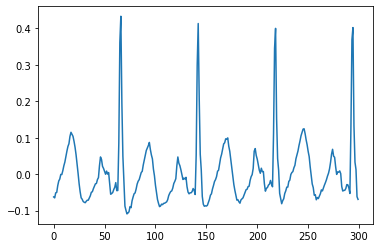

In [28]:
t0 = 500
delta_t = 300
plt.figure()
plt.plot(data_ecg[t0:t0+delta_t])
plt.show()

## QRS Segmentation

In [16]:
QRS_cplx_separated = np.zeros(data_ecg.shape)
QRS_cplx = []

Q_cplx = []
R_cplx = []
S_cplx = []

R_thres = 0.3
i=0
local_min = [float(data_ecg[0]), 0]
while(i<len(data_ecg)):
    if(data_ecg[i] > R_thres):
        local_max = [float(data_ecg[i]), i]
        i+=1
        while(data_ecg[i] > R_thres):
            if(data_ecg[i] > local_max[0]):
                local_max = [float(data_ecg[i]), i]
            i+=1
        R_cplx.append(local_max)
        local_min_S = getSfromR(data_ecg, local_max)
        S_cplx.append([data_ecg[local_min_S[1]],local_min_S[1]])
        local_min_Q = getQfromR(data_ecg, local_max)
        Q_cplx.append([data_ecg[local_min_Q[1]],local_min_Q[1]])
        local_max_P = getPfromQ(data_ma5, local_min_Q)
        QRS_idx = getQRSfromQandS(data_ecg, local_min_Q[1], local_min_S[1])
        QRS_cplx.append(data_ecg[QRS_idx[0]:QRS_idx[1]])
        QRS_cplx_separated[QRS_idx[0]:QRS_idx[1]] = data_ecg[QRS_idx[0]:QRS_idx[1]]
    i+=1
    
R_cplx = np.array(R_cplx)
S_cplx = np.array(S_cplx)
Q_cplx = np.array(Q_cplx)

### QRS identified

<IPython.core.display.Javascript object>


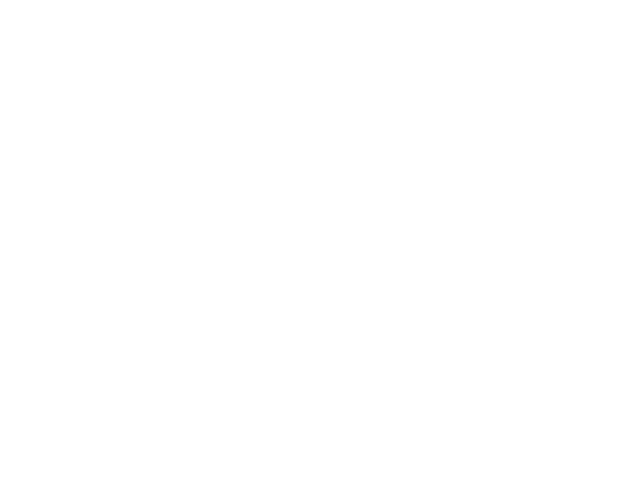

In [17]:
plt.figure()
plt.plot(data_n)
plt.scatter(R_cplx[:,1], R_cplx[:,0], marker=(5, 1))
plt.scatter(S_cplx[:,1], S_cplx[:,0], marker=(5, 1))
plt.scatter(Q_cplx[:,1], Q_cplx[:,0], marker=(5, 1))
plt.show()

### QRS separated

<IPython.core.display.Javascript object>


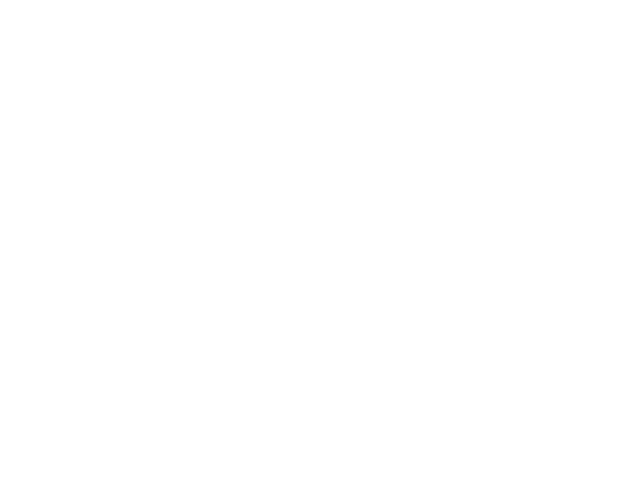

In [18]:
plt.figure()
for i in range(len(QRS_cplx)):
    plt.plot(QRS_cplx[i])
plt.show()

<IPython.core.display.Javascript object>


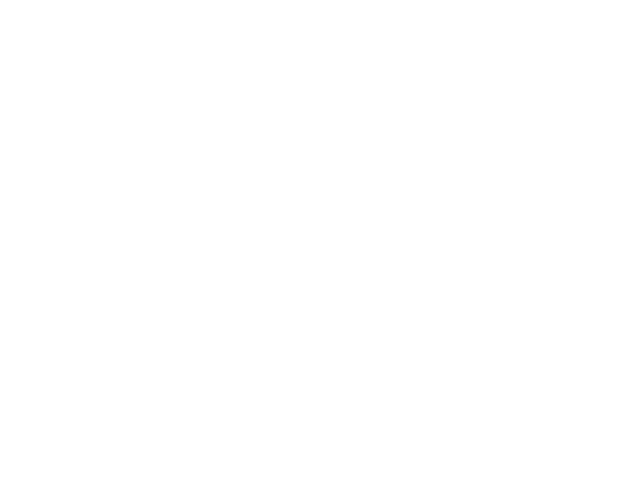

In [19]:
plt.figure()
plt.plot(QRS_cplx_separated)
plt.show()

## QRS Analysis

### Individual signals FFT

In [20]:
signal = QRS_cplx[100]
fs = 125
N = len(signal)
signal_fft = np.fft.fft(signal)/N
plotSignalAndFFT(signal, signal_fft, fs)

IndexError: list index out of range

In [ ]:
plotAllQrsSignalAndFFT(QRS_cplx, fs)

### Signals PSD

In [ ]:
signal = QRS_cplx[i]
fs = 125
N = len(signal)
f = np.linspace(0, fs, N)
t = np.linspace(0, 1/fs, N)
signal_fft = np.fft.fft(signal)/N
psd = 10*np.log10(np.abs(signal_fft)**2)

In [ ]:
plotQrsPSD(psd, fs)

In [ ]:
signal = QRS_cplx_separated
fs = 125
N = len(signal)
f = np.linspace(0, fs, N)
t = np.linspace(0, 1/fs, N)
signal_fft = np.fft.fft(signal)/N
psd = (1/(fs*N)) * np.abs(signal_fft)**2
plotQrsPSD(psd, fs)